<h1>How to Run Code:</h1>

In [46]:
# To run a test, edit this file name and run
# The file should contain data in the below format:
# Match Score
# Mismatch Penalty
# Gap Penalty
# Number of Sequences
# Sequences in fasta format

# If it contains only fasta data without the scores, change index to 4

filename = "test.txt"
index = 1


# Our algorithm usually takes around 1-2 mins for an input of the test size
DisplayResults(DivideAndConquerAntColony(filename, index))

Alligned Sequences are
-AATG-GTCATAGC
GAATCTGT-ATT--
TTGGGCGC-AT---
Sum of Pairs Score is 14
Sum of Pairs Score (with Penalty) is -29


<h1>Code</h1>

In [3]:
import Pkg; 
Pkg.add("FastaIO")
Pkg.add("Plots")
Pkg.add("BenchmarkTools")
using FastaIO
using Random
using StatsBase
using Dates
using Printf
using Plots
using BenchmarkTools


(process:14944): GLib-GIO-WARNING **: 16:10:11.615: Unexpectedly, UWP app `6760NGPDFLab.PDFX_1.3.7.0_x64__sbe4t8mqwq93a' (AUMId `6760NGPDFLab.PDFX_sbe4t8mqwq93a!App') supports 31 extensions but has no verbs


In [4]:
# This function reads DNA sequences from a FASTA file
function Read_Sequences_From_File(filename)
    sub=[] 
    FastaReader(filename) do fr
        for (desc, seq) in fr
            append!(sub,["$seq"])
        end
    end
    sub=[sub]
    return sub
end

Read_Sequences_From_File (generic function with 1 method)

In [5]:
### Start of Divide and Conquer ###

In [6]:
#longest string in DNA subseqs
function Longest_Seq(DNA)
    #length of DNA seqs
    len=zeros(Int16,length(DNA))
    f=0
    for i=1:length(DNA)
        len[i]=length(DNA[i])
        f=findmax(len)[2]
    end
    return f
end

Longest_Seq (generic function with 1 method)

In [7]:
#shortest string in DNA subseqs, return index
function Shortest_Seq(DNA)
    #length of DNA seqs
    len=zeros(Int16,length(DNA))
    s=0
    for i=1:length(DNA)
        len[i]=length(DNA[i])
        s=findmin(len)[2]
    end
    return s
end

Shortest_Seq (generic function with 1 method)

In [8]:
#PairSum--approximation of alignment score
#input two sequences
#output sum of score 
#from position 1 to length of seq1/2
function Pairwise_Score(seq1,seq2)
    e1=length(seq1)
    e2=length(seq2)
    c1_i=1
    c2_i=1
    s_s=0
    while (c1_i<=e1 && c2_i<=e2)
        #find the index of the first character matches seq1[c1_i] in seq2 
        if (occursin(seq1[c1_i],seq2[c2_i:e2])) 
            mtch2=findfirst(seq1[c1_i],seq2[c2_i:e2])
            s_s+=1
            c2_i=c2_i+mtch2
            c1_i=c1_i+1
        else
            break
        end
            #for seq1 start from the next position c1_i+1:e1 search seq[c2_i]
            #c2_i is the next position of the matched position 
        if ( c1_i<=e1 && c2_i<=e2 && occursin(seq2[c2_i],seq1[c1_i:e1]))
            mtch1=findfirst(seq2[c2_i],seq1[c1_i:e1])
            s_s+=1
            c1_i=c1_i+mtch1
            c2_i=c2_i+1
        else
            break
        end
    end
    return s_s
end

Pairwise_Score (generic function with 1 method)

In [9]:
#cut subsequence for a d vector
function Generate_Subseq(DNA,d)
    sub=[]
    sub1=[]
    sub2=[]
    for t=1:length(DNA)
        append!(sub1,[DNA[t][1:d[t]]])
        append!(sub2,[DNA[t][(d[t]+1):length(DNA[t])]])
    end
    append!(sub,[sub1])
    append!(sub,[sub2])
    return sub
end

Generate_Subseq (generic function with 1 method)

In [10]:
#score of subsequences generated from 1 d_cut position vector
function Cut_Score(DNA,d)
    scr_d=0
    sub=Generate_Subseq(DNA,d)
    for s=1:length(sub)
        for i=1:(length(sub[s])-1)
            for j=(i+1):length(sub[s])
                seq1=sub[s][i]
                seq2=sub[s][j]
                #from first to last
                #from last to first
                #from one sequence to the other
                # from the other seuqence to one sequence
                scr_d+=Pairwise_Score(seq1,seq2)
                scr_d+=Pairwise_Score(seq2,seq1)
                scr_d+=Pairwise_Score(reverse(seq1),reverse(seq2))
                scr_d+=Pairwise_Score(reverse(seq2),reverse(seq1))
            end
        end
    end
    return scr_d
end         

Cut_Score (generic function with 1 method)

In [11]:
#Randomly generate a population of k=100, each represent a possible solution of a cutoff
#DNA is the DNA sequences for multiple sequence alignment
#K is the number of possible solutions 
function Generate_kPop(DNA,K)
    pop=[]
    for k=1:K
        #1 possible solution
        d=zeros(Int16,length(DNA))

        for i=1:length(DNA)
            d[i]=rand(1:length(DNA[i]))
        end
        append!(pop,[d])
    end
    return pop
end    

Generate_kPop (generic function with 1 method)

In [12]:
#all k possible subseqs(sub1+sub2)
function K_Subseqs(DNA,k_pop)
    subseq=Matrix(undef,1,length(k_pop))
    for k in 1:length(k_pop)
        d=k_pop[k]
        subseq[k]=Generate_Subseq(DNA,d)
    end
    return subseq
end


K_Subseqs (generic function with 1 method)

In [13]:
#score of all k possible subseqs(sub1+sub2)
function K_Scores(DNA,k_pop)
    len=length(k_pop)
    d_score=zeros(Int16,len)
    k_subs=K_Subseqs(DNA,k_pop)
    for k in 1:length(k_subs)
        d=k_pop[k]
        d_score[k]=Cut_Score(DNA,d)
    end
    return d_score 
end


K_Scores (generic function with 1 method)

In [14]:
#the next population: new person in a k_pop
function Generate_new_p(DNA,k_pop,idx_best)
    #the longest seuqence f
    f=Longest_Seq(DNA)
    new=zeros(Int16,length(k_pop[idx_best]))
    for i in 1:length(new)
        new[i]=k_pop[idx_best][i]-k_pop[idx_best][f]+floor(1/2*length(DNA[f]))
        if new[i]>length(DNA[i])
            new[i]=length(DNA[i])
        end
        if new[i]<0
            new[i]=0
        end
    end  
    return new
end

Generate_new_p (generic function with 1 method)

In [15]:
function Cut_Best(DNA, k, Cycle, T)
    #the longest seuqence f
    f=Longest_Seq(DNA)
    # the founders in a population with k individual possible solutions 
    k_pop=Generate_kPop(DNA,k)
    k_scr=zeros(Int16,k)
    idx_best=0
    scr_best=0
    idx_wrst=0
    scr_wrst=0
    
    for gen=1:Cycle
        k_scr=K_Scores(DNA,k_pop)
        
        #find the current best score/current worst score
        idx_best=findmax(k_scr)[2]
        scr_best=findmax(k_scr)[1]
        idx_wrst=findmin(k_scr)[2]
        scr_wrst=findmin(k_scr)[1]

        #generate a new cutoff d-new, 
        d_new=Generate_new_p(DNA,k_pop,idx_best)
        scr_new=Cut_Score(DNA,d_new)
        #compare d_new with the worst socre
        #update the datasets k_pop,k_score
        if scr_new>scr_wrst
            k_pop[idx_wrst]=d_new
            k_scr[idx_wrst]=scr_new
        end
        #find the updated best/worst score
        idx_best=findmax(k_scr)[2]
        scr_best=findmax(k_scr)[1]
        idx_wrst=findmin(k_scr)[2]
        scr_wrst=findmin(k_scr)[1]

        # generate new cutoff by crossover and mutation
        for t in 1:T
            d_new=zeros(Int16,length(DNA))
            #chose two individual for X&M
            mt=rand((1:length(k_pop)),2)
            i=mt[1]
            j=mt[2]

            #mutation
            #which DNA mutate, cut position  
            c=rand(1:length(DNA))
            #mutate to a new cut position
            ran=rand(1:length(DNA[c]))

            #mutation and Xrsover in individual 1
            d_new=[k_pop[i][1:c];k_pop[j][(c+1):length(k_pop[j])]]
            #a mutation happens here
            d_new[c]=ran

           # for i=1:length(DNA)
           #     if(d_new[i]>length(DNA[i]))
           #         d_new[i]=length(DNA[i])
           #     end
           # end

            scr_new=Cut_Score(DNA,d_new)
            #update the datasets k_pop
            if scr_new>scr_wrst
                k_pop[idx_wrst]=d_new
                k_scr[idx_wrst]=scr_new
            end
            #update best/ worst score
            idx_best=findmax(k_scr)[2]
            scr_best=findmax(k_scr)[1]
            idx_wrst=findmin(k_scr)[2]
            scr_wrst=findmin(k_scr)[1]

            #X&M in pop2
            d_new=[k_pop[j][1:c];k_pop[i][(c+1):length(k_pop[i])]]
            #
            #for i=1:length(DNA)
            #    if(d_new[i]>length(DNA[i]))
            #        d_new[i]=length(DNA[i])
            #    end
            #end
            scr_new=Cut_Score(DNA,d_new)
            #update the datasets k_pop
            if scr_new>scr_wrst
                k_pop[idx_wrst]=d_new
                k_scr[idx_wrst]=scr_new
            end
            #update best/ worst score
            idx_best=findmax(k_scr)[2]
            scr_best=findmax(k_scr)[1]
            idx_wrst=findmin(k_scr)[2]
            scr_wrst=findmin(k_scr)[1]
        end
        #print(k_pop[idx_best])
    end
    return idx_best,k_pop[idx_best],k_scr[idx_best]
end

Cut_Best (generic function with 1 method)

In [16]:
#input a vector of multiple DNA sequences, or multiple subsets
#K number of initial populations 
#number of cycles for generating generations,
#T number of crossover and mutations in each generation
#M maximum length we could have in the subseuqences
#Minlength minimum length we could have in a subsequences
#output
#subsets of the sequences 
function Cut_Subs(sub,k, Cycle, T,M, MinLength)
    new_sub=[]
    #sub would have at least 1 set of sequences to be cut further
    #we would cut each subset
    for i=1:length(sub)
        f=Longest_Seq(sub[i])
        s=Shortest_Seq(sub[i])
        #if reach maximum length threshold or minimum length is 0, skip cutting
        if ((length(sub[i][f])<=M)&&(length(sub[i][f])>0))||(length(sub[i][s])==0)
            append!(new_sub,[sub[i]])
        else
            cut=Cut_Best(sub[i],k, Cycle, T)
            subGen = Generate_Subseq(sub[i],cut[2])
            s1=Shortest_Seq(subGen[1])
            s2=Shortest_Seq(subGen[2])
            subNew = []
            #if the newly generated subsequence reach the minlength threshold, don't cut.
            if (length(subGen[1][s1])>MinLength)
                push!(subNew,subGen[1])
            end
            if (length(subGen[2][s2])>MinLength)
                push!(subNew,subGen[2])
            end
            if (length(subNew) > 1)
                append!(new_sub,subNew)
            else
                append!(new_sub,[sub[i]])
            end
        end
    end
    return new_sub
end

Cut_Subs (generic function with 1 method)

In [17]:
#input a vector of multiple DNA sequences, should only have one set of DNA
#K number of initial populations 
#number of cycles for generating generations,
#T number of crossover and mutations in each generation
#M maximum length we could have in the subseuqences
#Minlength minimum length we could have in a subsequences
#output
#subsets of the sequences 
function Cut_Recur(sub,k, Cycle, T,M, MinLength)
#     println(sub[1][1])
    max_l=floor(1/2*length(sub[1][1]))
    sub_DNA=[]
    prevSub_DNA=[]
    #use maximum length and previous subset as control, 
    #jump out if reach the longest length or the previous subset is equal to the current subset
    while max_l>M
        sub_DNA=[]
        sub_DNA=Cut_Subs(sub,k, Cycle, T,M, MinLength)
        if(sub_DNA == prevSub_DNA)
            break
        end
        prevSub_DNA=sub_DNA
        max_l=0
        for i=1:length(sub_DNA)
            f=Longest_Seq(sub_DNA[i])
            if length(sub_DNA[i][f])>max_l
                max_l=length(sub_DNA[i][f])
            end
        end
        sub=[]
        sub=sub_DNA[:]
    end
    return sub
end

Cut_Recur (generic function with 1 method)

In [18]:
### Start of Ant Colony Optimization ###

In [19]:
# Initialize the pheromone array
# pheromone is a 4-dimensional array
# for every sequence (1st dimension), every nucleotide (second dimension)
# has a pheromone on the path to every other sequence's (third dimension) nucleotides (fourth dimension)
function Initialize_Pheromone(initial_pheromone, S)
    pheromone = Array{Any, 4}(undef, length(S), 1, 1, 1)
    for k = 1:length(S)   # k = starting point sequence
        pheromone[k] = Array{Array{Array{Float64}}}(undef, length(S[k]))
        for l = 1:length(S[k])   # l = starting point nucleotide
            pheromone[k][l] = Array{Array{Float64}}(undef, length(S))
            for n = 1:length(S)   # n = end point sequence
                pheromone[k][l][n] = Array{Float64}(undef, length(S[n]))
                for m = 1:length(S[n])   # m = end point nucleotide
                    pheromone[k][l][n][m] = initial_pheromone   # every path starts out with the initial_pheromone value
                end
            end
        end
    end
    return pheromone
end

Initialize_Pheromone (generic function with 1 method)

In [20]:
# Intialize the paths vector (a vector of Int64 vectors)
# every nucleotide from the sequence S[k] has a path that connects it to the best match in each other sequence
# for example S[k][1] will be the path (an Int64 vector) from the 1st nucleotide to a nucleotide in each of the other sequences
# an example of a path for S[k][1] when length(S) == 3 is [0, 2, 1]
# this means that S[k][1]'s best match in sequence 2 is the 2nd character, and the best match in sequence 3 is the 1st character
function Initialize_Paths(S, k)
    paths = Vector{Vector{Int64}}(undef, length(S[k]))
    for i = 1:length(S[k])
        paths[i] = zeros(Int64, length(S))
    end
    return paths
end

Initialize_Paths (generic function with 1 method)

In [21]:
# Adjust the pheromone after each sequence S[k] has been iterated through
function Adjust_Pheromone_1(S, pheromone, evap1, alignsum, average_score)
    for k = 1:length(S)   # k = starting point sequence
        for l = 1:length(S[k])  # l = starting point nucleotide
            for n = 1:length(S)   # n = end point sequence
                for m = 1:length(S[n])   # m = end point nucleotide
                    # update pheromone with equation given in paper
                    pheromone[k][l][n][m] = pheromone[k][l][n][m] * (1 - evap1) + (alignsum - average_score) * evap1
                end
            end
        end
    end
    return pheromone
end

Adjust_Pheromone_1 (generic function with 1 method)

In [22]:
# if the scores of all alignments in cycle is less than the score of alignments in the d cycles before, we should adjust the pheromone
function Adjust_Pheromone_2(S, pheromone, pheromone_threshold, evap2)  
    for k = 1:length(S)    # k = starting point sequence
        for l = 1:length(S[k])    # l = starting point nucleotide
            for n = 1:length(S)    # n = end point sequence
                for m = 1:length(S[n])   # m = end point nucleotide
                    if pheromone[k][l][n][m] > pheromone_threshold
                        pheromone[k][l][n][m] = pheromone[k][l][n][m] * (1-evap2)
                    end
                end
            end
        end
    end
    return pheromone
end

Adjust_Pheromone_2 (generic function with 1 method)

In [23]:
# the SP score of Sk[l], Sn[m], and all the selected characters
# according to Sk[l] before Sn[m]
function mat(S, k, l, n, m, paths)
    sum = Matching_Score(S[k][l], S[n][m])   # the SP score of Sk[l] and Sn[m]
    # find the SP scores of all the selected characters according to Sk[l] before Sn[m]
    for i = 1:(l-1)   # loop through columns of S[k] columns
        if paths[i][n] > 0    # nth nucelotide of paths[i]
            sum += Matching_Score(S[k][i], S[n][paths[i][n]])  # matching score between Sk[i] and the character it selected
        end
    end
    return sum
end

mat (generic function with 1 method)

In [24]:
# denotes the location deviation between m and the character selected
# according to Sk[l-1]
function dev(k, l, n, m, index_last_match_or_space)
    if index_last_match_or_space[n] == -1   # a gap
        return 0   # no deviation because it was a gap
    end
    return index_last_match_or_space[n] - m   # deviation between m and the last match
end

dev (generic function with 1 method)

In [25]:
# the start location of selecting characters in Sn according to Sk[l]
function loc(n, index_last_match)
    return index_last_match[n] + 1
end

loc (generic function with 1 method)

In [26]:
# selecting probability of Sn[m] according to Sk[l]
function P(S, k, l, n, m, paths, index_last_match, index_last_match_or_space, a, b, c, h, pheromone)
    sum = 0
    start_loc = loc(n, index_last_match)  # determine where to start

    for r = start_loc:minimum([start_loc + h, length(S[n])])   # check all nucleotides within range of h, unless we're at the end in which case check all nucleotides through end
        sum += (pheromone[k][l][n][r]*a + mat(S,k,l,n,r,paths)*b + dev(k,l,n,r,index_last_match_or_space)*c)  # summation from paper
    end

    return (pheromone[k][l][n][m]*a + mat(S,k,l,n,m,paths)*b + dev(k,l,n,m,index_last_match_or_space)*c) / sum  # probability equation from paper
end

P (generic function with 1 method)

In [27]:
# determine matching score between two nucleotides or gaps
# note: these score/penalty values were changed from the ones used in the paper 
# as these values got us better SP scores when penalties were applied
function Matching_Score(Sij, Skj)
    alphabet = ['A', 'C', 'G', 'T']    # valid nucleotides
    if Sij in alphabet && Skj in alphabet   # either a match or mismatch, no gaps
        if Sij == Skj   # match
            return 1
        else            # mismatch
            return -1
        end
    elseif (Sij in alphabet && Skj == '-') || (Sij == '-' && Skj in alphabet)  # nucleotide paired with gap
        return -1
    else   # both are "-"
        return -1
    end
end

Matching_Score (generic function with 1 method)

In [28]:
# using paths, form the alignment

# paths is a vector of Int64 vectors, where each i-th Int64 vector is the path from Sk[i] to matches in other sequences
# and each j-th element in the i-th Int64 vector is the index of the match in the j-th sequence

# alignment is an array of Char arrays, where each i-th char array is the aligned i-th sequence
function Form_Alignment(S, paths, k)
    # initialize the alignment
    alignment = Array{Array{Char}}(undef, length(S))  
    for i = 1:length(S)
        alignment[i] = Array{Char}(undef, 0)
    end

    previous_nucleotide_index = zeros(Int64, length(S))  # the indices of the previous nucleotide chosen from each sequence
    for l = 1:length(S[k])   # loop through path for Sk, starting at each nucleotide Sk[l]
        path = paths[l]      # get the path for the l-th nucleotide in Sk
        current_length = length(alignment[1])   # the length of the alignment so far; used to determine how many gaps to add
        # calculate the number of characters to add
        # -- it's the maximum difference between the matching index from path and the index of the previous nucleotide chosen
        num_chars_to_add = maximum(path .- previous_nucleotide_index)  
        new_length = current_length + num_chars_to_add  # calculate new length of alignment after all chars are added  
        
        for (i, match_index) in enumerate(path)  # iterate through the path, selecting the corresponding nucleotide from sequence i
            if match_index == -1   # the "index" of a gap
                push!(alignment[i], '-')
            else
                # first fill in missing nucleotides between this path's selection and last path's
                # determine how many nucleotides were skipped between last match and this one
                # and append those nucleotides to alignment sequence before adding this match
                num_nucleotides_skipped = match_index - previous_nucleotide_index[i] - 1   
                if num_nucleotides_skipped > 0
                    skipped_nucleotides = collect(S[i][(previous_nucleotide_index[i]+1):(previous_nucleotide_index[i]+num_nucleotides_skipped)])
                    append!(alignment[i], skipped_nucleotides)
                end
                
                # pad with spaces if needed to get new length
                current_length = length(alignment[i])  # new current length after adding skipped nucleotides
                while current_length < new_length - 1  # if we're still below the new length, fill in spaces
                    push!(alignment[i], '-')
                    current_length += 1
                end

                # finally, add the nucleotide given by the match_index in path
                push!(alignment[i], S[i][match_index])
                previous_nucleotide_index[i] = match_index  # update previous_nucleotide_index to this one
            end

            if l == length(S[k])  # last iteration -- fill in anything left
                # how many of the nucelotides in original sequence did we use?
                alignment_no_spaces = filter(x -> x != '-', alignment[i])   # filter out the gaps
                alignment_length = length(alignment_no_spaces)   # this is how many nucleotides we have in the aligned sequence
                sequence_length = length(S[i])    # this is how many nucleotides we want to have
                
                # if the alignment doesn't have all of the original sequence, append whatever's left
                if alignment_length < sequence_length  
                    num_nucleotides_left = sequence_length - alignment_length
                    append!(alignment[i], collect(last(S[i],num_nucleotides_left)))
                end
            end

        end
    end

    # now that we're done, determine maximum alignment length, and make all alignments the same length by appending gaps
    # first determine max length
    max_length = 0
    for i = 1:length(alignment)
        if length(alignment[i]) > max_length
            max_length = length(alignment[i])
        end
    end

    # for any alignment that is less than max length, append spaces until lengths are equal
    for i = 1:length(alignment)
        alignment_length = length(alignment[i])
        if alignment_length < max_length
            num_spaces_needed = max_length - alignment_length
            for j = 1:num_spaces_needed
                push!(alignment[i], '-')
            end
        end
    end
    
    # convert the Char vectors into strings, and return a vector of strings representing the aligned sequences

    alignment_strs = Vector{String}(undef, length(S))
    for i = 1:length(S)
        alignment_strs[i] = String(alignment[i])
    end
    return alignment_strs
end

Form_Alignment (generic function with 1 method)

In [29]:
# Calculate the sum of pairs score between all alignments using equation given in paper
function SP_Score(alignment)
    L = length(alignment[1])
    N = length(alignment)
    sum = 0
    for j = 1:L   # column
        for i = 1:(N-1)  # sequence 1
            for k = (i+1):N   # sequence 2
                sum += Matching_Score(alignment[i][j], alignment[k][j])
            end
        end
    end
    return sum
end

SP_Score (generic function with 1 method)

In [30]:
# Adjust a, the importance of pheromone when calculating probability, using equation from paper
function Adjust_a(a, va, ta, sa)
    a = a * (1 + va)
    if a > ta
        a = sa
    end
    return a
end

Adjust_a (generic function with 1 method)

In [31]:
# Adjust b, the importance of matching location when calculating probability, using equation from paper
function Adjust_b(b, vb, tb, sb)
    b = b * (1 - vb)
    if b < tb
        b = sb
    end
    return b
end

Adjust_b (generic function with 1 method)

In [32]:
# Adjust c, the importance of location deviation when calculating probability, using equation from paper
function Adjust_c(c, vc, tc, sc)
    c = c * (1 - vc)
    if c < tc
        c = sc
    end
    return c
end

Adjust_c (generic function with 1 method)

In [33]:
function AntColony(S)
    # initialize parameters. Note: Paper did not give any of these values. They were educated guesses altered via experimentation.
    a = 0.1  # pheromone parameter (smaller than b and c to start)
    b = 0.4  # matching location parameter
    c = 0.4  # location deviation parameter
    d = 4  # number of cycle before for comparing alignments
    h = 10  # range of character selecting
    evap1 = 0.1  # evaporation coefficient
    evap2 = 0.1  # evaporation coefficient
    pheromone_threshold = 0.75  # if pheromone levels pass this threshold, evaporate by evap2
    va = 0.5  # velocity of adjusting a
    vb = 0.5  #velocity of adjusting b
    vc = 0.5  #velocity of adjusting c
    ta = 0.75  # threshold of a
    tb = 0.1  # threshold of b
    tc = 0.1  # threshold of c
    sa = 0.75  # initialized value of a
    sb = 0.1  # initialized value of b
    sc = 0.1  #  initialized value of c
    initial_pheromone = 0.1
    prob_of_space = 0.06  # probability of selecting a space
    average_score = 0
    alignments_so_far = 0
    start = 5
    Cyclenum = 40
    index_last_match = zeros(Int64, length(S))   # the index of the last match in each sequence. does not include spaces.
    index_last_match_or_space = zeros(Int64, length(S))  # the index of the last match in each sequence. index of -1 means it was a space
    pheromone = Initialize_Pheromone(initial_pheromone, S)  # denotes the pheromone when selectiong Sn[m] according to Sk[l]
    N = length(S)  # so we don't keep calculating the length of S
    best_alignment = nothing  # keep track of best alignment over all iterations
    best_score = nothing      # keep track of score of best alignment over all iterations
    best_score_this_cycle = nothing   # keep track of best score this cycle
    worst_score_this_cycle = nothing  # keep track of worst score this cycle
    min_score_in_last_d_cycles = Vector{Int64}()   # holds the minimum alignment score for the last d cycles

    for cycle = 1:Cyclenum                  # Cyclenum is the number of iterations
        best_score_this_cycle = nothing     # keep track of best score for this cycle
        worst_score_this_cycle = nothing    # keep track of worst score for this cycle
        for k = 1:N                         # circulation of Sk
            paths = Initialize_Paths(S, k)  # initialize paths
            for l = 1:length(S[k])          # circulation of Sk[l]
                for n = 1:N                 # circulation of Sn
                    if n == k               # sequences are the same
                        paths[l][n] = l     
                    else                     # Select a space or a character in Sn
                        max_probability = nothing  # initialize
                        m_for_max_probability = nothing  # initialize
                        start_loc = loc(n, index_last_match)  # get location to start searching (can't go backwards)
                        if start_loc > length(S[n])   # we've reached the end of sequence Sn, can only match to gaps now
                            select = -1   # -1 is the "index" that indicates a gap
                        else
                            # calulate m that makes probability maximal
                            # try to match as far out as h will allow, unless we're at the end, then only try to match up to end
                            for m = start_loc:(minimum([start_loc + h - 1, length(S[n])]))  
                                # calculate probability and keep track of which m gives the highest probability
                                probability = P(S, k, l, n, m, paths, index_last_match, index_last_match_or_space, a, b, c, h, pheromone)
                                if max_probability == nothing || probability > max_probability
                                    max_probability = probability
                                    m_for_max_probability = m
                                end
                            end
                            m = m_for_max_probability
                            if S[n][m] == S[k][l]   # if Sn[m] is the same nucleotide as Sk[l], choose that nucelotide
                                select = m
                            else    # otherwise, select a space with predetermined probability, or the next nucleotide in the sequence with remaining probability
                                select = StatsBase.sample([-1, start_loc], StatsBase.weights([prob_of_space, 1 - prob_of_space]))
                            end
                        end
                         # keep track of what the last index was
                        index_last_match_or_space[n] = select    # set this regardless of if gap or nucleotide
                        if select > -1
                            index_last_match[n] = select         # only set this if not a gap
                        end
                        paths[l][n] = select  # put the selection on the path
                    end
                end
            end
            
            # we have a path for every nucleotide in Sk. Time to form the alignment
            alignment = Form_Alignment(S, paths, k)
            score = SP_Score(alignment)
            
            # Adjust best overll alignment
            if best_alignment == nothing || score > best_score
                best_alignment = alignment
                best_score = score
            end
            
            # Adjust best and worst score this cycle
            if best_score_this_cycle == nothing || score > best_score_this_cycle
                best_score_this_cycle = score
            end
            if worst_score_this_cycle == nothing || score < worst_score_this_cycle
                worst_score_this_cycle = score
            end          
            
            # calculate average score
            average_score = (average_score * alignments_so_far + score) / (alignments_so_far + 1) # calculate average this way instead of storing array of scores
            alignments_so_far += 1
            
            # adjust pheromone
            pheromone = Adjust_Pheromone_1(S, pheromone, evap1, score, average_score) 
            
            # reset indices of last matches for next iteration
            index_last_match = zeros(Int64, length(S))
            index_last_match_or_space = zeros(Int64, length(S))
        end
        
        # if we've passed a certain point ('start' number of cycles), evaporate pheromone if needed
        # evaporation is needed if the best score of this cycle was worse than the worst score of the previous d cycles
        if cycle > start && best_score_this_cycle < minimum(min_score_in_last_d_cycles)
            pheromone = Adjust_Pheromone_2(S, pheromone, pheromone_threshold, evap2)
        end
        
        # append new worst score to min_score_in_last_d_cycles
        if length(min_score_in_last_d_cycles) >= d  # shift if needed
            min_score_in_last_d_cycles = min_score_in_last_d_cycles[2:end]
        end
        append!(min_score_in_last_d_cycles, worst_score_this_cycle)
        
        # adjust importance of pheromone (a), importance of matching score (b), and importance of location deviation (c)
        a = Adjust_a(a, va, ta, sa)
        b = Adjust_b(b, vb, tb, sb)
        c = Adjust_c(c, vc, tc, sc)
    end
    
    # once we've completed all cycles, return the best alignment and score out of all of them
    return best_alignment, best_score
end

AntColony (generic function with 1 method)

In [34]:
### End of Ant Colony Optimization ###

In [35]:
function ReadSequencesFromTxtFile(fileName::String,index=1)
#     numberOfSequences = Integer(floor(countlines(fileName)/2))
    Sequences = []
    currSequence=""
    matchScore = "1"
    misMatchScore = "-1"
    gapScore = "-2"
    for line in eachline(fileName)
        if index == 1
            matchScore = line
        elseif index == 2 
            misMatchScore = line
        elseif index == 3 
            gapScore = line
        elseif index == 4
        else 
            if length(line) < 1
                continue
            end
            if(line[1]=='>')
                if length(currSequence) != 0
                    push!(Sequences,currSequence)
                    currSequence = ""
                end
            else
                currSequence = currSequence * line
            end
        end
        index+=1
    end
    if length(currSequence) !=0
        push!(Sequences,currSequence)
    end
    return matchScore,misMatchScore,gapScore,Sequences
end

ReadSequencesFromTxtFile (generic function with 2 methods)

In [36]:
function SumOfPairs(Sequences) 
    numberOfSequences = length(Sequences)
    lengthOfSequence = length(Sequences[1])
    answer = 0
    for i=1:numberOfSequences
        Seq1 = Sequences[i]
        for j=i+1:numberOfSequences
            Seq2 = Sequences[j]
            for k = 1:lengthOfSequence
                if Seq1[k] == Seq2[k] && Seq1[k] != '-'
                    answer += 1
                end
            end    
        end
    end
    return answer
end

SumOfPairs (generic function with 1 method)

In [37]:
function SumOfPairsPenalty(Sequences,matchPenalty="1",mismatchPenalty="-1",gapPenalty="-2")
    matchPenalty = parse(Int64,matchPenalty)
    mismatchPenalty = parse(Int64,mismatchPenalty)
    gapPenalty = parse(Int64,gapPenalty)
    numberOfSequences = length(Sequences)
    lengthOfSequence = length(Sequences[1])
    answer = 0
    for i=1:numberOfSequences
        Seq1 = Sequences[i]
        for j=i+1:numberOfSequences
            Seq2 = Sequences[j]
            for k = 1:lengthOfSequence
                if Seq1[k] == Seq2[k] && Seq1[k] != '-'
                    answer += matchPenalty
                elseif Seq1[k] != Seq2[k] && Seq1[k] != '-' && Seq2[k] != '-' 
                    answer += mismatchPenalty
                elseif Seq1[k] == '-' || Seq2[k] == '-'
                    answer += gapPenalty
                end
            end    
        end
    end
    return answer
end

SumOfPairsPenalty (generic function with 4 methods)

In [38]:
# This function displays the results once the allignment has been completed
function DisplayResults(AllignmentResult)
    AllignedSeq = AllignmentResult[1]
    println("Alligned Sequences are")
    for alSeq in AllignedSeq
        println(alSeq)
    end
    println("Sum of Pairs Score is " * string(AllignmentResult[2]))
    println("Sum of Pairs Score (with Penalty) is " * string(AllignmentResult[3]))
end

DisplayResults (generic function with 1 method)

In [40]:
# The function that actually runs the algorithm
function DivideAndConquerAntColony(fileName :: String,index=1,InitPop = 100, Cycles = 40, CrossOvers = 40)
    matchScore,misMatchScore,gapScore,Sequences = ReadSequencesFromTxtFile(fileName,index)
    OrigSequences = [Sequences]
    MaxLength = 25
    MinLength = 10
    longestLength = 0;
    for seq in Sequences
        if length(seq)>longestLength
            longestLength = length(seq)
        end
    end
    MaxLength = floor(Int, longestLength/8)
    MinLength = floor(Int, longestLength/30)
    if MaxLength == 0 || MinLength == 0
        MaxLength = 2
        MinLength = 1
    end
    numberOfRetries = 5
    bestAllignment = nothing
    bestSumOfPairsScore = -1000000000
    bestSumOfPairsPenaltyScore = -1000000000
    while numberOfRetries > 0
        Sequences = OrigSequences
        Sequences=Cut_Recur(Sequences,InitPop,Cycles,CrossOvers,MaxLength,MinLength)
    #     println(Sequences)
        final_alignment = Vector{String}(undef, length(Sequences[1]))
        for sequences in Sequences # todo change this name
            alignment, score = AntColony(sequences)
            for (index, aligned_subsequence) in enumerate(alignment)
                if !isassigned(final_alignment, index)
                    final_alignment[index] = ""
                end
                final_alignment[index] *= aligned_subsequence
            end
        end

        sumOfPairsScore = SumOfPairs(final_alignment)
        sumOfPairsPenaltyScore = SumOfPairsPenalty(final_alignment,matchScore,misMatchScore,gapScore)
        if sumOfPairsScore>bestSumOfPairsScore && sumOfPairsPenaltyScore>bestSumOfPairsPenaltyScore 
            bestSumOfPairsScore=sumOfPairsScore
            bestSumOfPairsPenaltyScore=sumOfPairsPenaltyScore
            bestAllignment=final_alignment
        end
        numberOfRetries-=1
    end
    return bestAllignment, bestSumOfPairsScore, bestSumOfPairsPenaltyScore
end

DivideAndConquerAntColony (generic function with 5 methods)

In [ ]:
### Some tests ###

In [111]:
# Our algorithm usually takes around 1-2 mins for an input of the test size
# Test is a file which contains data in the below format
# Match Score
# Mismatch Penalty
# Gap Penalty
# Number of Sequences
# Sequences in fasta format
X=DivideAndConquerAntColony("test.txt")
AllignedSeq = X[1]
println("Alligned Sequences are")
for alSeq in AllignedSeq
    println(alSeq)
end
println("Sum of Pairs Score is " * string(X[2]))
println("Sum of Pairs Score (with Penalty) is " * string(X[3]))

Alligned Sequences are
AATGGTCATAGCGAGATGAAGCCACGTGATGGATA-ATATTGTG-CAAA-C-GA-C-C--TTAT-TA-G-CTATTGACCGTCGAT----------G-TCCAACGAGA-CAA--TT
GAATCTGTATTCTTCAAGCTTCAAC--------TC-C-AT-GCA-CTA--C-GA-A-CGGT-AG-T--G-G--TTCACATT--------------G-ACCGTG------------
TTGGGCGCATTGACCGTCCTTCCTAGCG-----TATC-AT-CAAACTT--GTGA-TTCTCT-ATCTA-GAG-C-AAAATGCGGTGTCCGCTATATG-GAGATCTATTTCAAAATA
GTTACATATCAG-AA-TCATTAGAAACGCTCT-TA-A-TG-GGG-TTAAGCAGAGA-CT-T-AG-TAAG-G-ATTAACTCCCAAGAT--------GATTGACCGTGCTC------
Sum of Pairs Score is 186
Sum of Pairs Score (with Penalty) is -586


In [41]:
# Running for all test cases takes approximately 10 minutes!

# These are the tests given by the instructors
Test1=DivideAndConquerAntColony("givenTest1.txt")
println("Results for Test1")
DisplayResults(Test1)
println()
Test2=DivideAndConquerAntColony("givenTest2.txt")
println("Results for Test2")
DisplayResults(Test2)
println()
Test3=DivideAndConquerAntColony("givenTest3.txt")
println("Results for Test3")
DisplayResults(Test3)
println()

Results for Test1
Alligned Sequences are
AATGGTC-ATAGCGAGATGAAGCCA-CGT--GATGGA--TAAT-ATTGTGCAAACGACCTTATTA-GCTA-TTGACCGTCGATGTCCAACGAGA-CAA--TT
GAATCTGTATTCTTCAAGCTTCA---ACTC-CATGCAC-TACG-AA------------------C-GGTAGTGGTTC-ACATTGACCGT-G-----------
TTGGGCGCATTGACCGTCCTTCCTAGCGTATCATCAAACTTGTGATTCTCTAT-CTAGAGCAAAATGCGGTGTCCGC-TATATGGAGATCTATTTCAAAATA
Sum of Pairs Score is 86
Sum of Pairs Score (with Penalty) is -228

Results for Test2
Alligned Sequences are
-ATGAACGACGAA--ACACAATT-T---ACAAATA-AGGC-C----AACGAAATTATCCGTTTGGCCCAGAAATTGGCTC-AGGATCACAGA-C--AT--GC-T------CAG-T--T--A-C-AACCAATTCAC-TT--ACTTGCTG----CA-TTT-GT-TGAGCCAAACGA----G-GATGGTTC-
-ATGGCTGATTATCCTTTTACTG-A----CAAAGC-CG-C-AAAG-A-C-A--TTGTC--T-GA-TGCGTACTC-------AATTGCAC-AATCTTA-------------TGG-TCATTCA-C-AATTAACCCCTATTCACATTGCTGCTG-CTCTTTTGTCCGACAGTGACAGTAACG-G-TAC----
-ATGAACGACGAA--ACGAAGTTTACGAACAAAGCTCT-CGA---TATC-A--TCA-CCAT-TG-CACAGAAACT------AGCA-CAG-GA-CC-ACCAGCATTCGACGCTGGT--GC-CTCTAC--------------ACGTGCTTGCAGCG-TTC-GT

In [ ]:
### Start of benchmarking ###

In [120]:
# This function is used to create plot data for generating the plots 
scoreSumOfPairsVsLength =[]
scoreSumOfPairsPenaltyVsLength =[]
ReferenceScoreSumOfPairsVsLength =[]
ReferenceScoreSumOfPairsPenaltyVsLength =[]
timeVsLength = []
memoryVsLength = []
LengthOfSeq = []

scoreSumOfPairsVsNumber =[]
scoreSumOfPairsPenaltyVsNumber =[]
ReferenceScoreSumOfPairsVsNumber =[]
ReferenceScoreSumOfPairsPenaltyVsNumber =[]
timeVsNumber = []
memoryVsNumber = []
NumberOfSeq = []

function genPlotData(inputFilesPathLength :: String, referenceAllignmentPathLength :: String, inputFilesPathNumber :: String, referenceAllignmentPathNumber :: String)
    println(Dates.format(now(), "HH:MM"))
    for i in 4:2:200
        file = "4X" * string(i) * ".fasta"
        append!(LengthOfSeq,i)
        fileName = inputFilesPathLength * file
        refFileName = referenceAllignmentPathLength * file
        pt=@timed DivideAndConquerAntColony(fileName,4)
        refSequence = ReadSequencesFromTxtFile(refFileName,4)
        refSequence = refSequence[4]
        refSequenceScore_sp = SumOfPairs(refSequence)
        refSequenceScore_spmp = SumOfPairsPenalty(refSequence)
        append!(scoreSumOfPairsVsLength,pt[1][2])
        append!(scoreSumOfPairsPenaltyVsLength,pt[1][3])
        append!(ReferenceScoreSumOfPairsVsLength,refSequenceScore_sp)
        append!(ReferenceScoreSumOfPairsPenaltyVsLength,refSequenceScore_spmp)
        append!(timeVsLength,pt.time)
        append!(memoryVsLength,pt.bytes/(1024*1024))
    end
    for i in 4:1:25
        file = string(i) * "X40.fasta"
        append!(NumberOfSeq,i)
        fileName = inputFilesPathNumber * file
        refFileName = referenceAllignmentPathNumber * file
        pt=@timed DivideAndConquerAntColony(fileName,4)
        refSequence = ReadSequencesFromTxtFile(refFileName,4)
        refSequence = refSequence[4]
        refSequenceScore_sp = SumOfPairs(refSequence)
        refSequenceScore_spmp = SumOfPairsPenalty(refSequence)
        append!(scoreSumOfPairsVsNumber,pt[1][2])
        append!(scoreSumOfPairsPenaltyVsNumber,pt[1][3])
        append!(ReferenceScoreSumOfPairsVsNumber,refSequenceScore_sp)
        append!(ReferenceScoreSumOfPairsPenaltyVsNumber,refSequenceScore_spmp)
        append!(timeVsNumber,pt.time)
        append!(memoryVsNumber,pt.bytes/(1024*1024))
    end
    println(Dates.format(now(), "HH:MM"))
end

# WARNING!!! This generates data for plotting and takes approximately 2.5 hours only uncomment this if you are recreating the plots
# genPlotData("C:\\Users\\rahul\\Desktop\\NCSU Courses\\Molecular Biology\\Project\\MSA-AntColony\\Test-LengthOfSequenceUnalligned\\","C:\\Users\\rahul\\Desktop\\NCSU Courses\\Molecular Biology\\Project\\MSA-AntColony\\Test-LengthOfSequenceAlligned\\",
# "C:\\Users\\rahul\\Desktop\\NCSU Courses\\Molecular Biology\\Project\\MSA-AntColony\\Test-NumberOfSequenceUnalligned\\","C:\\Users\\rahul\\Desktop\\NCSU Courses\\Molecular Biology\\Project\\MSA-AntColony\\Test-NumberOfSequenceAlligned\\")
# println(Dates.format(now(), "HH:MM"))

scoreSumOfPairsVsLength=[15, 14, 24, 42, 25, 62, 50, 62, 78, 48, 52, 79, 106, 106, 84, 106, 100, 120, 117, 114, 142, 119, 144, 136, 182, 177, 144, 165, 191, 155, 185, 204, 187, 183, 165, 278, 211, 290, 209, 229, 307, 261, 254, 257, 356, 272, 260, 350, 327, 313, 409, 354, 297, 341, 301, 256, 334, 202, 337, 393, 299, 386, 377, 331, 415, 311, 384, 505, 486, 403, 363, 401, 444, 369, 421, 571, 432, 436, 478, 388, 358, 423, 424, 409, 481, 627, 497, 479, 454, 566, 492, 569, 542, 478, 415, 504, 662, 447, 637]
scoreSumOfPairsPenaltyVsLength=[-9, -44, -45, -48, -78, 25, -108, -117, -26, -140, -140, -125, -199, -93, -170, -63, -254, -194, -196, -144, -201, -178, -322, -301, -148, -232, -318, -281, -179, -357, -400, -414, -306, -526, -566, -139, -380, -168, -432, -490, -246, -299, -275, -377, -280, -521, -632, -291, -550, -442, -163, -491, -549, -537, -535, -826, -503, -765, -621, -506, -702, -609, -463, -750, -595, -934, -842, -509, -617, -687, -712, -882, -663, -871, -794, -228, -686, -591, -659, -834, -835, -715, -1095, -983, -823, -490, -916, -924, -1188, -514, -1179, -1036, -920, -936, -1119, -1104, -466, -1247, -500]
ReferenceScoreSumOfPairsVsLength=[11, 19, 23, 44, 17, 65, 41, 52, 72, 50, 61, 96, 104, 101, 81, 97, 118, 106, 123, 104, 157, 135, 151, 132, 170, 189, 138, 177, 203, 182, 191, 188, 181, 233, 199, 277, 222, 288, 262, 231, 363, 287, 290, 310, 348, 262, 296, 353, 367, 280, 419, 363, 319, 377, 321, 351, 359, 187, 377, 431, 357, 423, 430, 433, 483, 357, 408, 578, 600, 437, 421, 432, 522, 358, 505, 640, 498, 419, 565, 487, 367, 450, 392, 449, 530, 702, 553, 580, 547, 651, 642, 640, 585, 552, 496, 525, 753, 463, 777]
ReferenceScoreSumOfPairsPenaltyVsLength=[-2, -34, -2, -30, -68, 46, -248, -104, -36, -68, -90, -44, -166, -12, -136, -131, -226, -218, -42, -151, -34, -122, -175, -291, -163, -89, -354, -348, -155, -347, -314, -256, -249, -173, -452, -76, -324, 3, -355, -292, 141, -96, -161, -312, -144, -712, -456, -51, -364, -460, 19, -257, -395, -392, -406, -714, -274, -879, -406, -213, -522, -523, -212, -285, -356, -678, -627, -135, -124, -301, -472, -474, -254, -925, -381, 231, -406, -669, -284, -666, -1023, -711, -1123, -1175, -614, -23, -605, -602, -677, -186, -574, -586, -442, -786, -746, -1175, -194, -1128, -281]
timeVsLength=[0.080236, 0.2092777, 1.8906801, 2.0595817, 1.5345465, 2.8995333, 3.6381629, 3.4528378, 3.6668849, 4.5126314, 4.4234906, 6.9689753, 9.3810405, 7.6344882, 8.9610641, 9.1134208, 12.1528707, 11.4834783, 10.2835987, 10.1793653, 13.5976624, 14.0496104, 18.5324276, 17.9753994, 15.1491412, 14.4555067, 16.4092098, 18.2875847, 14.4259596, 20.6159742, 18.3912832, 21.1372562, 14.5575007, 26.5916646, 22.7131043, 23.0516585, 32.6235517, 18.5873168, 25.682552, 31.6495046, 23.8472115, 20.8518592, 23.7554476, 24.8816332, 24.9247159, 26.8308892, 26.4555112, 34.3770967, 28.6277764, 25.4189736, 23.047431, 29.5855912, 33.401433, 34.2049393, 24.1368122, 32.6037959, 34.7274963, 62.7043834, 37.7155697, 41.3600439, 49.3475324, 45.3138954, 90.0224514, 45.9652464, 48.0054974, 65.3068847, 47.7053503, 44.6836637, 48.3151841, 52.3683993, 44.1068468, 57.9395207, 36.9375964, 80.9897373, 53.0627988, 42.3014563, 53.3443214, 43.6088441, 48.7468645, 97.4983906, 39.3282567, 76.3586481, 55.596019, 73.9454138, 83.9389438, 58.6244992, 73.9161355, 69.712126, 71.2605587, 62.9026246, 95.6863522, 74.7277321, 77.5521568, 66.8567012, 68.4637143, 78.0346713, 87.5943229, 79.4163998, 88.4069357]
memoryVsLength=[40.229156494140625, 146.50234985351562, 1196.066162109375, 1340.3479766845703, 991.8712921142578, 1874.027099609375, 2461.1666412353516, 2322.571243286133, 2503.5927734375, 2885.164077758789, 2945.4327697753906, 4591.468078613281, 6527.978378295898, 4912.629104614258, 5920.775665283203, 6041.214584350586, 7956.671035766602, 7754.3201904296875, 6961.844741821289, 6737.4954833984375, 9305.520935058594, 9523.38037109375, 12271.912673950195, 13073.83984375, 10153.803985595703, 10271.469223022461, 11330.306427001953, 12442.079147338867, 9794.348556518555, 14235.837219238281, 12970.545303344727, 14483.298278808594, 9872.209350585938, 19631.54281616211, 16136.49348449707, 16894.97819519043, 24925.307907104492, 13211.782485961914, 18752.970138549805, 24166.569274902344, 18061.396881103516, 15038.465957641602, 17746.799392700195, 17936.281295776367, 18695.0379486084, 21921.4482421875, 21094.92234802246, 28645.230545043945, 23064.84602355957, 21336.300704956055, 20657.160247802734, 26341.75259399414, 28395.236053466797, 29758.805252075195, 20899.422409057617, 28108.602508544922, 29958.97492980957, 49477.36729431152, 29268.118209838867, 31047.64584350586, 38723.90872192383, 35639.50038146973, 71705.8706817627, 35608.27354431152, 38278.8397064209, 51563.791259765625, 35162.94990539551, 35918.916595458984, 39786.91833496094, 42224.47521972656, 35384.84848022461, 46846.59130859375, 30516.6025390625, 68292.59204101562, 45000.423767089844, 34979.30009460449, 44982.49180603027, 35722.72741699219, 40823.64616394043, 79203.44157409668, 31311.886032104492, 63032.50895690918, 43876.8405456543, 60485.088806152344, 67245.38070678711, 50683.06852722168, 63539.58349609375, 61695.24725341797, 62511.75291442871, 55434.59248352051, 87623.1061706543, 64667.829818725586, 66739.96868896484, 58761.909423828125, 83794.28604125977, 86129.28953552246, 75621.8267211914, 69410.04161071777, 78463.16848754883]
LengthOfSeq=[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200]
scoreSumOfPairsVsNumber=[146, 179, 305, 453, 604, 812, 1054, 1282, 1311, 1270, 1795, 1886, 2516, 2179, 2776, 3184, 3410, 2984, 4524, 3816, 4667, 4736]
scoreSumOfPairsPenaltyVsNumber=[-229, -429, -649, -902, -875, -1057, -1614, -2172, -2164, -4473, -2259, -5244, -7783, -5395, -8999, -10020, -8945, -8384, -8657, -11327, -4683, -14442]
ReferenceScoreSumOfPairsVsNumber=[159, 173, 324, 467, 665, 961, 1113, 1514, 1563, 1540, 2077, 2361, 3031, 2972, 4005, 4362, 4589, 4554, 5754, 5305, 7065, 6680]
ReferenceScoreSumOfPairsPenaltyVsNumber=[-69, -210, -654, -350, -329, -216, -449, -414, -695, -3043, -2063, -3693, -4566, -1766, -10133, -5124, -6988, -3805, -5569, -9515, -2976, -13305]
timeVsNumber=[12.8485023, 15.1404669, 29.1115087, 34.6439105, 56.2017146, 67.9241408, 81.8459167, 106.1301321, 106.118304, 125.2801505, 159.5746444, 180.4400455, 223.0883144, 186.9405305, 279.8293367, 346.1132484, 336.2458292, 313.0538729, 430.0615112, 429.8611951, 492.6471562, 475.4269209]
memoryVsNumber=[8616.31884765625, 10259.847549438477, 19453.768524169922, 22753.166610717773, 36185.97888183594, 44736.10275268555, 52621.674743652344, 68579.59687805176, 66001.25190734863, 79022.65530395508, 101020.60269165039, 117798.35856628418, 145434.3758239746, 121112.43656921387, 180102.53007507324, 222229.07426452637, 217379.58235168457, 200082.46601867676, 270497.31315612793, 298699.8110809326, 332850.13693237305, 325559.0208129883]
NumberOfSeq=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

println("Done with Creating Plot Data")

Done with Creating Plot Data


In [67]:
plot(NumberOfSeq,timeVsNumber,title = "Time of DC-Ant Colony vs Number of DNA Seq",label="Time")
xlabel!("Number of DNA Sequences")
ylabel!("Time of Algorithm (in seconds)")
savefig("NumberVsTime.png")

In [68]:
plot(NumberOfSeq,memoryVsNumber,title = "Memory of DC-Ant Colony vs Number of DNA Seq",label="Memory")
xlabel!("Number of DNA Sequences")
ylabel!("Memory of Algorithm (in MB)")
savefig("NumberVsMemory.png")

In [69]:
plot(NumberOfSeq,[scoreSumOfPairsVsNumber,ReferenceScoreSumOfPairsVsNumber],title = "Sum of Pairs Score Comparison", label = ["DC-Ant Colony Score" "Reference Score"])
xlabel!("Number of DNA Sequences")
ylabel!("Score of Algorithm")
savefig("NumberVsScore.png")

In [70]:
plot(NumberOfSeq,[scoreSumOfPairsPenaltyVsNumber,ReferenceScoreSumOfPairsPenaltyVsNumber],title = "Sum of Pairs (with Penalty) Score Comparison", label = ["DC-Ant Colony Score" "Reference Score"])
xlabel!("Number of DNA Sequences")
ylabel!("Score of Algorithm")
savefig("NumberVsScore(Penalty).png")

In [71]:
plot(LengthOfSeq,timeVsLength,title = "Time of DC-Ant Colony vs Length of Seq",label="Time")
xlabel!("Length of DNA Sequence")
ylabel!("Time of Algorithm (in seconds)")
savefig("LengthVsTime.png")

In [72]:
plot(LengthOfSeq,memoryVsLength,title = "Memory of DC-Ant Colony vs Length of Seq",label="Memory")
xlabel!("Length of DNA Sequence")
ylabel!("Memory of Algorithm (in MB)")
savefig("LengthVsMemory.png")

In [73]:
plot(LengthOfSeq,[scoreSumOfPairsVsLength,ReferenceScoreSumOfPairsVsLength],title = "Sum of Pairs Score Comparison", label = ["DC-Ant Colony Score" "Reference Score"])
xlabel!("Length of DNA Sequence")
ylabel!("Score of Algorithm")
savefig("LengthVsScore.png")

In [123]:
plot(LengthOfSeq,[scoreSumOfPairsPenaltyVsLength,ReferenceScoreSumOfPairsPenaltyVsLength],title = "Sum of Pairs (with Penalty) Score Comparison", label = ["DC-Ant Colony Score" "Reference Score"])
xlabel!("Length of DNA Sequence")
ylabel!("Score of Algorithm")
savefig("LengthVsScore(Penalty).png")

In [6]:
score = [-506, -405, -446, -377, -517, -454, -496, -567, -546, -416, -536, -556, -563, -591, -523, -596, -571, -616, -587, -685, -722, -647, -734, -776, -728, -748]
prob_of_space = [0.00:0.02:0.5]
plot(prob_of_space, [score], title="Sum of Pairs (with Penalty) vs Prob of Gap", label=["Score"])
xlabel!("Probability of Gap")
ylabel!("Sum of Pairs (with Penalty) Score")
savefig("ScoreVsProbOfSpace.png")

In [7]:
score = [-428, -378, -390, -424, -399, -434, -316, -402, -441, -396, -427, -369, -411, -528, -477, -464, -408, -383, -530, -532, -505]
prob_of_space = [0.00:0.01:0.2]
plot(prob_of_space, [score], title="Sum of Pairs (with Penalty) vs Prob of Gap", label=["Score"])
xlabel!("Probability of Gap")
ylabel!("Sum of Pairs (with Penalty) Score")
savefig("ScoreVsProbOfSpace_focused.png")

In [ ]:
### End of Code ###

<h1>Documentation</h1>

<h2>Summary</h2>
<p>
We have implemented the algorithm described in “An efficient algorithm for multiple sequence alignment based on ant colony optimization and divide-and-conquer method” by Wei Liu, Ling Chen, and Juan Chen (2007). This algorithm consists of three parts: Divide and Conquer, Ant Colony Optimization, and Assembly. 
</p>
<p>
In the Divide and Conquer stage, a genetic algorithm is used to find the best way to divide the DNA sequences into more manageable chunks. First, K possible solutions are randomly generated to form a population. A simplified version of sum of pairs is used to calculate the score of each possible solution. In each of the following generations, a new solution based on the current best solution is generated. In addition, T times of mutation and crossover operations are performed to generate new possible solutions. For each new possible solution, its score is evaluated and compared with the current scores. In the population, the worst solution is always replaced by a better new solution, left with the top K solutions in each generation. When the number of generations reaches a certain number, the Divide and Conquer returns the best cutoff positions for each sequence. By applying this procedure recursively, the original set of sequences are divided into 2, 4, 8, ... subsets until the length of sequences in subsets reaches a certain threshold. The overall complexity of Divide and Conquer is O(N^2*Len*T*C*log⁡(len)), in which N is the number of sequences, T is the number of mutation and crossover operations, C is the number of new generations of the population, Len is the length of the longest sequence, log⁡(len) is the approximate number of subsets. 
</p>
<p>
The next stage then aligns each of these subsequences using an Ant Colony Optimization heuristic. In this step, we loop through every nucleotide from every sequence, with an “ant” forming a path from each of these nucleotides to its best match in every other sequence. As each path is formed, the ant “pheromone” is updated, eventually leading more ants to choose the more popular (and hopefully best) paths. After every nucleotide in a sequence has a path, an alignment of all the sequences is formed from the paths, and its sum of pairs score is calculated. This is repeated for every sequence, keeping track of the best alignment. Once all sequences have formed an alignment, the process is repeated a predetermined number of times, with the best scoring alignment returned. Pheromone levels are adjusted between cycles to prevent local optimization. The computation complexity of the Ant Colony Optimization is O(N^2*Len*Cycle * log(Len)), in which N is the number of sequences, Cycle is the number of iterations “ants” travel, and Len is the length of the longest sequence. 
</p>
<p>
Finally, after each set of subsequences is aligned, they are reassembled to form one overall alignment. This is done by simply concatenating the aligned subsequences together. The time complexity is O(N*log(len)), where again N is the number of sequences and len is the length of the longest sequence.
</p>
<p>
To test our results, we created DNA sequences using Rose, simulating DNA sequences with varying numbers of sequences and lengths of sequences. We benchmarked each of these sets of sequences, determining how these changes affected runtime and memory, and we compared their Sum of Pairs scores to those of the solutions given by Clustal Omega and Rose. 
</p>
<p>
In terms of performance, we found that both the runtime and memory usage increased quadratically as the number of DNA sequences increased. Both runtime and memory appeared to have an nlogn relationship as the length of the DNA sequences increased.  For accuracy, we performed similarly to Rose for shorter sequences and a smaller number of sequences, but performed a bit worse when the length or number of sequences increased. The eight tests that we compared to Clustal Omega with varying sequence number and length did not perform as well as Clustal Omega. 
</p>


<h2>Materials and Methods</h2>
<h3>The Algorithm</h3>
<p>
The algorithm, based on Liu et al 2007, consists of three stages: Divide and Conquer, Ant Colony Optimization, and Assembly. Each of these stages is described below.
</p>

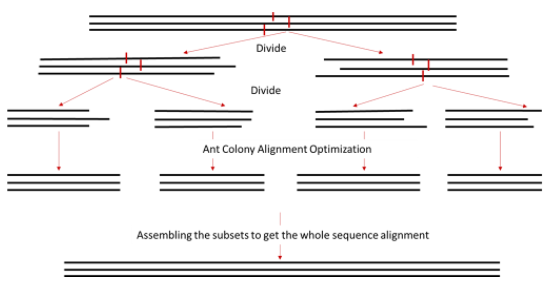

<h4>Divide and Conquer</h4>
<p>
    This first stage divides the DNA sequences into more manageable subsequences. The cutoff points are optimized using a genetic algorithm.
</p>
<p>
    We recursively find cutoff points for each sequence to produce a set of subsequences. Starting from one set of sequences, we can produce 2, 4, 8, 16, … subsequences, until reaching the predefined subsequence length. This predefined length is a function of the length of the sequences, with longer sequences resulting in longer subsequence lengths. We define d as an array of cutoff points, where each element of d represents the cutoff points for one sequence. Cutoff points will be evaluated with a score function. Because this evaluation is repeated a large number of times, a simplified version of sum of pairs is used to reduce computation time. 
</p>
<p>
    The simplified version of sum of pairs is implemented in four steps. First, starting from sequence 1[1], find the first matching character in sequence 2 from left. Denote  this character as sequence 2[j], then find the first matching character after sequence 1[1]. Continue till the end of either sequence. The second to fourth step replicates the same procedure but starting from different positions in both sequences.
</p>

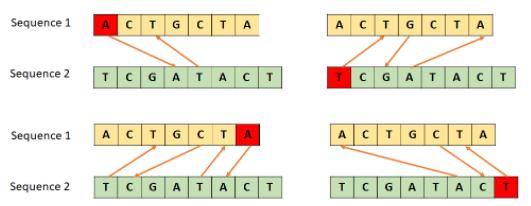

<p>
A genetic algorithm is used to optimize the cutoff points to get the highest alignment score. This genetic algorithm consists of 3 stages: initiation, mutation and crossover, and termination. In the initiation stage, we randomly generate k possible solutions in generation 0. We use the aforementioned score function to evaluate the performance of each solution. The current best score is used as a benchmark for further analysis. The next stage, mutation and crossover, creates the subsequent generations. For each generation p, we perform mutation and crossover to produce new possible solutions for generation p+1. The idea is that the new possible solution borrows information from the current best solution, with randomly generated mutations, and the crossover generates new solutions by swapping parts of two current solution vectors. We use the same score function to calculate the performance of the new solution. If the new solution is better than the worst solution in generation p, this worst solution is replaced with the new solution. Repeat this process -- finding the best and worst score, generating a new possible solution, comparing its score with the previous worst score, and replacing the worst score with the new solution -- a predetermined number of times. The k solutions with highest scores are stored in a k by s matrix, where k is the number of possible solutions and s is the number of sequences. Finally, after a predetermined number of cycles, the termination stage outputs the best solution, which is the approximation of the global optimization of the cutoff points.
</p>

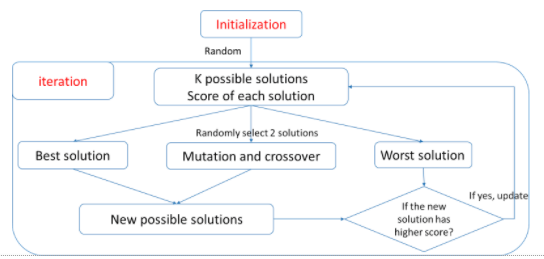

The pseudocode for the Divide and Conquer stage of our algorithm is shown below.

Input: N sequences: S1 ,S2,…… ,SN

Output: The optimal cut-off: d[best]

Begin

1 Randomly generate K cut-off, called POP

2 For population = 1 to CYCLE do

2.1 Calculating the best cut-off in POP, let its index be best

2.2 Calculating a new cut-off according to new[i]=best[i]-best[f]+f_half_length. # Here, f is the index of the longest sequence.
if new is better than the worst cut-off in POP,
replace it by new

2.3 generating new cut-offs by T mutations and crossover

if mutation or crossover cutoff solution is better than the worst cut-off in POP,

replace worst cut-off  by the better solution

Remaining K cut-offs of high quality

endfor-population

<p>3. Return (d[best]), where best is the index of the best cut-off in POP
end</p>

For the computation complexity of the Divide and Conquer: calculation of sum of pair(simplified version) is of O(N^2 * len). The sum of pair function is applied for each subset log(len), each generation C, T times of mutation and crossover. The overall complexity is O(N^2 * Len * T * C * log⁡(len)).


<h4>Ant Colony Optimization</h4>

The second stage, Ant Colony Optimization, (implemented in the AntColony function), takes the subsequences produced by the Divide and Conquer stage and aligns each set of them. This is done in two main steps that are repeated many times: forming paths and forming alignments. A path is formed when an “ant” moves from a nucleotide from one sequence to its best match in each of the other sequences. Paths from each nucleotide in a sequence form one possible alignment. This is repeated for every sequence, with the best scoring alignment remaining. Then this entire sequence is repeated a predetermined number of times to find the best approximation.

To form these paths, we cycle through each sequence of the set of sequences, S, using the index k. Within each sequence Sk, we cycle through each nucleotide with index l, and an “ant” forms a path for that nucleotide. This is done by cycling through S once again, this time with index n. For each sequence Sn, if n != k (i.e., we’re not forming a path between a sequence and itself), we determine which nucleotide in Sn has the highest probability of matching with Sk[l], using the function P, which implements the equation in Figure ?. This equation considers the pheromone along each possible path (the pheromone variable) with how well it matches (the mat function) and how far the location deviates from the starting point (the dev function), to produce the probability that a given nucleotide Sn[m] is the best match. If the nucleotide with highest probability matches the nucleotide Sk[l], we select it. Otherwise, we choose either a space or the next nucleotide in sequence Sn, selecting a space with a predetermined probability and the nucleotide with the remaining probability. This is done using the sample function of the Julia StatsBase library, which will select a value from an array of options using the given probabilities. Once we select a matching nucleotide, a mismatched nucleotide, or a space, we put the index, m, of the nucleotide (or -1 for a space) into the paths[l] array, at index n; this indicates that the l-th nucleotide of sequence Sk maps to the m-th nucleotide of the n-th sequence.


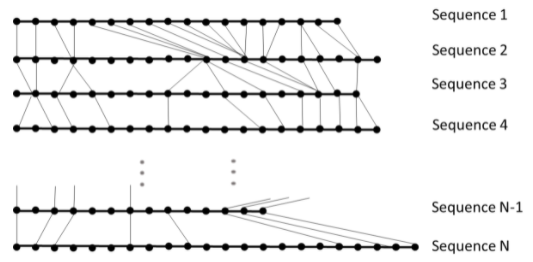

Once we have formed a path for every nucleotide in sequence Sk, we form an alignment. This was not described in the paper, but our implementation is done in the Form_Alignment function. We initialize a variable, alignment, as an array of char arrays; each of these char arrays is one of the aligned sequences. Next, we initialize the Int64 array previous_nucleotide_index, whose i-th element is the index of the previous nucleotide incorporated from sequence i. We once again loop through sequence Sk using index l. We define path as paths[l], the path formed by the ant starting at nucleotide Sk[l]. For this l-th nucleotide, we first determine how many  characters will be added in total to keep the alignments the same length. This is done by finding the maximum of the difference between each sequence’s index in path and its previous_nucleotide_index. This is how many characters we will need to add to each alignment, whether they are gaps, the chosen nucleotide, or skipped nucleotides. Now, we iterate over path, with each i-th element of path telling us the match_index of the nucleotide from sequence SI that was selected, or a space if the match_index is -1. If it’s -1, we simply add a gap to alignment[i]. Otherwise, we first need to determine which nucleotides were between the previously selected nucleotide and the currently selected nucleotide, and we append those to alignment[i] so that they are not skipped. Next, we look at the new current_length, and if this is less than the previously determined new_length, we pad with gaps until there is one character remaining to add. Finally, we add the selected nucleotide at match_index to alignment[i]. After every iteration, each char array in alignment should be the same length.

Once we have finished looping through the paths, on the last iteration, we need to fill in any remaining nucleotides that were after the last-selected nucleotide in each sequence so that the end of the sequences are not skipped. These remaining nucleotides are appended to their corresponding alignments. Finally, since all alignments must be the same length, we determine the maximum length of the alignments and fill in the shorter sequences with gaps. 

Now that we have an alignment, we score it using the SP_Score function, which cycles through every combination of pairs and scores them depending on if they are a match, a mismatch, a nucleotide paired with a gap, or a pair of gaps. We deviated from the paper here: they used scores of +2, -1, -2, and 0 respectively, while we used scores of +1, -1, -1 and -1. If the score of this alignment is better than the best alignment so far, we keep the alignment and update the best score.

After forming this alignment based on Sk, we adjust the pheromone along the paths using Adjust_Pheromone_1 to avoid local optimizations. We then repeat the process for the next sequence, Sk+1, until we have formed an alignment based on every sequence.

At this point, we’re done with a cycle, so we adjust a few more parameters. Pheromone is further adjusted using Adjust_Pheromone_2, only if the best score from this cycle was worse than the worst score from the previous d cycles. We also adjust a, b, and c, the importance of pheromone, matching score, and location deviation, respectively, when calculating probability. We then repeat this entire process for a predetermined number of cycles. Finally, the best alignment from all of the cycles is returned.

The pseudocode for the Ant Colony Optimization stage of our algorithm is shown below.

```
input: N sequences: S[1],S[2],……,S[N]

Output: The optimal alignment of S[1],S[2],……,S[N] and score of the alignment: alignsum

Begin

Initialization

for cycle = 1 to Cyclenum do # Cyclenum is the number of iterations
    for k = 1 to N do # Circulation of S[k], starting sequence
        for l= 1 to length(S[k]) do # Circulation of S[k][l]
            for n = 1 to N do # Circulation of S[n], end sequence
                if n!=k then # Select a space or a character in S[n]           
                    for m = loc(k,l,n) to loc(k,l,n)+h-1 do
                       calculate P(k,l,n,m), keeping track of highest probability   
                    end for m
                    m = value of m that maximized P(k,l,n,m)
                    if (S[n][m]) = S[k][l]) then 
                        select Sn(m)
                    else 
                        select a space based on a probability
                        select S[n][loc(k,l,n)) based on the remaining probability
                    end if
                end if
            end for n
        end for l
        form a whole alignment (see pseudocode below)
        calculate the score of the alignment, keeping best alignment
        Update the pheromone 
    end for k
    if the alignment is the best, keep it
    if cycle>start and best score this cycle < worst score over last d cycles
        adjust the pheromone
    end if
    Adjust the parameters a, b, c
end for Cyclenum
return best alignment and score
end
```

The pseudocode for the FormAlignment part of the Ant Colony Optimization algorithm is below.

```
Input: S -- the original sequences, paths -- the vector of path vectors, and k -- the starting sequence index

Output: alignment -- a vector of strings representing the aligned sequences

Begin
for l in starting sequence length
	calculate new length of alignment based on maximum number of nucleotides that will be added
	for i, match_index in path
		if match_index represents a space
            append a space to alignment[i]
        else
            fill in missing nucleotides between this path’s selection and last path’s
            pad with spaces if needed to get to new length - 1
            add the nucleotide given by the match_index in path
        end if
        if last iteration
            append any nucleotides that were after the last match
		end if
    end for i, match_index
end for l
append gaps to alignments to make them all the same size
return alignment
End
```

For the computation complexity, when searching region h is small compared to length of sequence,  the ant selects characters on other sequences takes O(Len * N). Ants are equally assigned to every sequence. The Ant Colony function is applied multiple times (Cyclenum) to choose the optimal. The overall complexity is O(N^2 * Len * Cyclenum) . Since this is done for roughly log(Len) subsequences, the complexity of the entire Ant Colony Optimization is O(N2 * Len * Cyclenum * log(Len)).


<h4>Assembly</h4>
The final stage is Assembly. In this step, the aligned subsequences returned from the Ant Colony Optimization step are reassembled to form one long alignment. The subsequences are simply concatenated back together in their original order to form this final alignment.

The pseudocode for this step is below:
```
Input: subsequence_alignments -- the alignments of each subsequence, stored as a vector of vectors of aligned subsequence strings

Output: final_alignment -- an array of aligned subsequence strings representing the final alignment

Begin
initialize final_alignment to all empty strings
for each subsequence_alignment in subsequence_alignments
    for each sequence with index i
        final_alignment[i] = final_alignment[i] + subsequence_alignment[i]
    end
end
return final_alignment
End 
```

The outer loop runs roughly log(len) times while the inner loop runs N times, so the complexity of this step is O(N * log(len)).

<h3>Evaluating Parameters</h3>

There were many parameters involved in our algorithm -- the Ant Colony Optimization step alone had over 20 parameters, none of which were given in the paper. Unfortunately, due to time constraints, we had to make educated guesses for many of them, testing just a few different values to get an idea of a reasonable value. A few that seemed significant were the probability of a space (prob_of_space), the number of cycles to consider before globally adjusting pheromone (d), and the number of nucleotides to compare against when finding a match (h), so we tested these in more depth. Using a test set of 4 sequences around length 90, prob_of_space was first varied from 0.00:0.02:0.5, then we focused on the best region, varying prob_of_space by 0.01 and running the algorithm multiple times for each test, taking the optimal score. d was varied from 0:2:10 on the same small set of sequences, and the optimal value was found. h was varied from 5:5:30 on the same set of sequences, and the optimal value was found as well.

<h3>Evaluating Performance</h3>

Our performance evaluations were concerned with three things: runtime, memory usage, and accuracy. For all experiments we used Rose software to simulate custom DNA sequences with varying number of sequences and lengths of sequences. For the purpose of testing our accuracy, we used the Clustal Omega and Rose reference alignment scores for the same sets of DNA sequences. We used two matching schemes for scoring: Sum-Of-Pairs (+1 for match, 0 otherwise) and Sum-Of-Pairs-With-Penalty (+1 for match, -1 for mismatch, and -2 for a gap).

First we tested accuracy for 8 sets of generated DNA sequences of various lengths and number of sequences. Using the same matching scores, we scored our solutions and the solutions of Rose and Clustal Omega. These scores were tabulated for comparison.

Then we determined how runtime, memory usage, and accuracy varied with respect to number of sequences and sequence length. For the comparisons against length of DNA sequences, we used sequences of length 4 - 200, with the number of DNA sequences set to 4. For comparisons against the number of DNA sequences, we varied the number of sequences from 4-25 with the length of DNA sequences set to 40. Runtime and memory usage were determined using the @timed function of the BenchmarkTools library and plotted against number of sequences and sequence length. To plot accuracy, we plotted both scores (Sum of Pairs and Sum of Pairs with Penalty) of our solutions against the Rose solution scores for the same sequences. 


<h3>Modifications from Paper</h3>

There were several modifications we made from the paper. A lot of detail was missing, such as parameter values and how to form an alignment. As previously mentioned, for the parameter values, we started off with our best guesses and through some trial and error found somewhat optimal values. For the parameters that seemed to significantly affect score, we ran more thorough tests as previously described. The algorithm for forming an alignment from a path was only very briefly described in the paper, so that was up to our interpretation as well. 

We also modified the Divide and Conquer portion in a few ways. In the original paper, the Divide and Conquer step continues the process even if no better cut locations are obtained in subsequent cycles. For our algorithm, we modify it such that if no better cut locations are obtained, we do not proceed further. This helps save additional cycles. Another modification was making the subsequence size limits depend on the length of the original sequence. This is done so that as the length of the sequence increases, the number of chunks that we are breaking into decreases and it leads to a time improvement. We also observed increased accuracy by doing this.

<h2>Results and Analysis</h2>

<h3>Results of Parameter Evaluation</h3>

The results of varying prob_of_space over a wide range (0 to 50%) are shown below. 

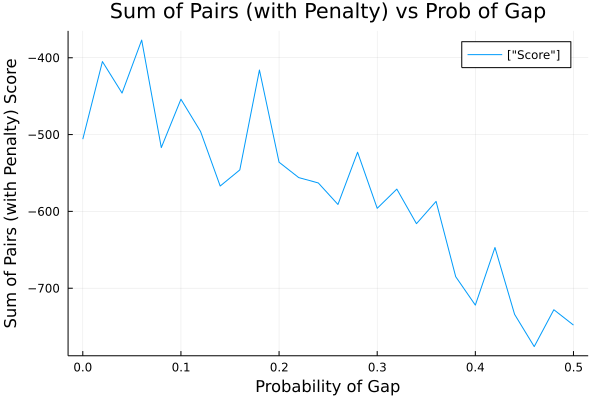

We saw that the score was optimal at lower values of prob_of_space, so we focused on the region between 0 and 0.2, which is shown in the plot below. The optimal value in both plots was 0.06.

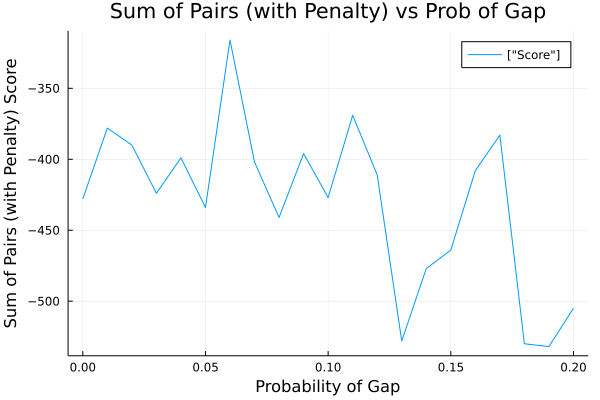

The results of varying d over a range of 0:2:10 are shown below. The optimal value of d was found to be 4, but there did not seem to be a trend in this plot.  

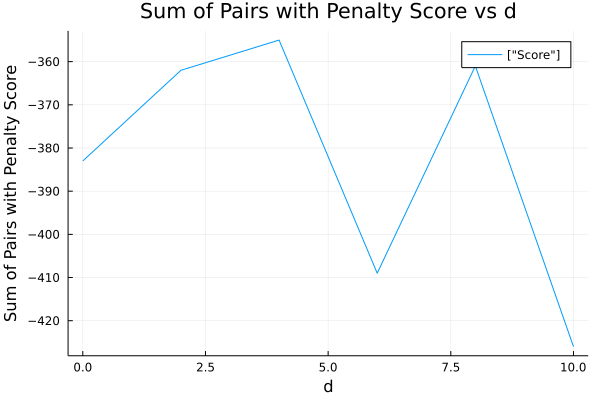

The results of varying h over a range of 1:4:30 are shown below. There is no definite trend, but it seemed to do better for smaller values of h. The optimal value of h after a few of these tests was found to be around 10.

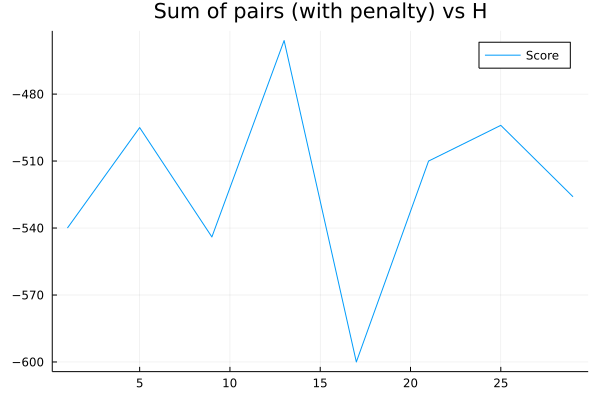

<h3>Example Alignments</h3>

Alligned Sequences are

AATGGTCATAGCGAGATGAAGCCACGTGATGGATA-ATATTGTG-CAAA-C-GA-C-C--TTAT-TA-G-CTATTGACCGTCGAT----------G-TCCAACGAGA-CAA--TT

GAATCTGTATTCTTCAAGCTTCAAC--------TC-C-AT-GCA-CTA--C-GA-A-CGGT-AG-T--G-G--TTCACATT--------------G-ACCGTG------------

TTGGGCGCATTGACCGTCCTTCCTAGCG-----TATC-AT-CAAACTT--GTGA-TTCTCT-ATCTA-GAG-C-AAAATGCGGTGTCCGCTATATG-GAGATCTATTTCAAAATA

GTTACATATCAG-AA-TCATTAGAAACGCTCT-TA-A-TG-GGG-TTAAGCAGAGA-CT-T-AG-TAAG-G-ATTAACTCCCAAGAT--------GATTGACCGTGCTC------

Sum of Pairs Score is 186

Sum of Pairs Score (with Penalty) is -586


This alignment is shown below using the MView tool.

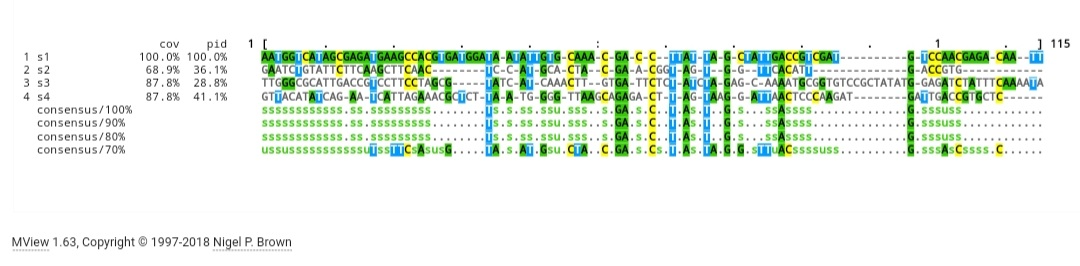

<h4> Results for tests given by instructors</h4>

<h4>Results for Test1</h4>
    
Results for Test1

Alligned Sequences are

AATGGTC-ATAGCGAGATGAAGCCA-CGT--GATGGA--TAAT-ATTGTGCAAACGACCTTATTA-GCTA-TTGACCGTCGATGTCCAACGAGA-CAA--TT

GAATCTGTATTCTTCAAGCTTCA---ACTC-CATGCAC-TACG-AA------------------C-GGTAGTGGTTC-ACATTGACCGT-G-----------

TTGGGCGCATTGACCGTCCTTCCTAGCGTATCATCAAACTTGTGATTCTCTAT-CTAGAGCAAAATGCGGTGTCCGC-TATATGGAGATCTATTTCAAAATA

Sum of Pairs Score is 86

Sum of Pairs Score (with Penalty) is -228

    
<h4>Results for Test2</h4>
        
Alligned Sequences are

-ATGAACGACGAA--ACACAATT-T---ACAAATA-AGGC-C----AACGAAATTATCCGTTTGGCCCAGAAATTGGCTC-AGGATCACAGA-C--AT--GC-T------CAG-T--T--A-C-AACCAATTCAC-TT--ACTTGCTG----CA-TTT-GT-TGAGCCAAACGA----G-GATGGTTC-

-ATGGCTGATTATCCTTTTACTG-A----CAAAGC-CG-C-AAAG-A-C-A--TTGTC--T-GA-TGCGTACTC-------AATTGCAC-AATCTTA-------------TGG-TCATTCA-C-AATTAACCCCTATTCACATTGCTGCTG-CTCTTTTGTCCGACAGTGACAGTAACG-G-TAC----

-ATGAACGACGAA--ACGAAGTTTACGAACAAAGCTCT-CGA---TATC-A--TCA-CCAT-TG-CACAGAAACT------AGCA-CAG-GA-CC-ACCAGCATTCGACGCTGGT--GC-CTCTAC--------------ACGTGCTTGCAGCG-TTC-GT-AGAGACAC-CTG----CTGAT-GGTAG

-ATGAACGACGAA--ACACA--------ACAAATA-AGGC-C----AACGAAATTATCCGTTTGGCCCAGAAATTGGC-TCAGGATCACAGA-C--AT--GC-T------CAG-T--T--A-C-AACCAATTCAC-TT--ACTTGCTG----CA-TTT-GT-TGAGCCAAACGA----G-GATGGTTC-

-ATGAACGACGAA--ACGAAGTTTACGAACAAAGCTCT-C-G----A-T-A--CCAT-----TG-CACAGAAACT------AGCA-CAG-GA-CC-ACCAGCATTCGACGCTGGT--GC-CTCTA-C-------------ACGTGCTTGCAGCG-TTC-GT-AGAGACAC-CTG----CTGATGCGTAG

TATGGCTGATTATCCTTTTACTG-A----CAAAGC-CG-C-AAAG-A-C-A--TTGTC--T-GATCTC-------------AATTGCAC-AATCTTA-------------TGG-TCATTCA-C-AATTAACCCCTATTCACATTGCTGCTG-CTCTTTTGTCCGACAGTGACAGTAACG-G-TAC----

Sum of Pairs Score is 1154

Sum of Pairs Score (with Penalty) is -1673

        
<h4>Results for Test3</h4>
            
Alligned Sequences are

-ATGAACGACGAAAC-ACAA-TT-T-AC-AA-A-TAAG-GCCAA-C-GAAATTATCCGTTTGGCCCAGAAATTGGCTCAGG-ATCACAGACATGC---TC-AG-T-TACAACCAAT--T-C-A-C-TT-A-C--T--T-G---------C--T-G-CATTTGTTGAGC-----CA-AA-CGAGGATG-GTTC

-ATGGCTGATT-----A-TCCTT-TTACTGACA-AAGCCGCAA--A-GACATTGTCTGATG--CGTACTCAATTGCA-----CAATCTTATGGTCAT-TCACAAT-T-AACCCC-TA-TTC-A-CATT-G-C--TGCT-GCTCTT----T--T-GTCC------GA-CAGTGACAGTAACG-GTAC------

-ATGAACGACGAAACGA-AG-TT-T-AC-GA-A-CAAA-GCTCT-C-GATATCATCACCATTGCACAGAAACTAGCA-----CAGGACCACC------AG-CA-T-T-CGACGC-TGGTGC-CTC-TACA-CG-TGCTTGCAGCG----T--TCG-TAG----AGA-CA----CC-TG-CT-G-ATG-GTAG

-ATGAACGACGAAAC-ACAA-CA-A-AT-AA-GGCCA-------AC-GAAATTATCCGTTTGGCCCAGAAATTGGCTCAGGA-TCACAGACATGC---TC-AG-T-TACAACCAAT--T-C-A-C-TT-A-C--T--T-G---------C--T-G-CATTTGTTGAGC-----CA-AA-CGAGGATG-GTTC

-ATGAACGACGAAACGA-AG-TT-T-AC-GA-A-CAAA-GCTCT-C-GATACCATTGC------ACAGAAACTAG-------CACAGGACCACC----AG-CA-T-T-CGACGC-TGGTGC-CTC-TACA-CG-TGCTTGCAGCG----T--TCG-TAG----AGA-CA----CC-TG-CT-G-ATGCGTAG

TATGGCTGATT-----A-TCCTT-TTACTGACA--AAG-CCGCA-AAGACATTGT--------CTGATCTCAATTGCAC---AATCTTATGGTCAT--TCACAAT-T-AACCCC-TATT-C-A-CATT-G-C--TGCT-GCTCTT----T--T-GTCC------GA-CAGTGACAGTAACG-GTAC------

-ATGAACGACG-----A-AC-AAAT-AA-GG-C-CAA--------C-GAAATTATCCGTTTGGCCCAGAAATTGGCTCA---GGATCACAGACC----AG-CA-T-T-CGACGC-TGGTGC-CTC-TACA-CG-TGCTTGCAGCG----T--TCG-TAG----AGA-CA----CC-TG-CT-G-ATG-GTAG

-ATGAACGACGAAACGA-AG-TT-T-AC-GA-A-CAAA-GCTCT-C-GATACCATT-G-----CACAGAAACTAGCA-----CAGGAG-CATT-----TCACAAT-T-AACCCC-TATT-C-A-CATT-G-C--TGCT-GCTCTT----T--T-GTC-C-----GA-CAGTGACAGTAACG-GTAC------

TATGGCTGATT-----A-TCCTT-TTACTGACA-AAGCCGCA---AAGACATTGT--------CTGAT--------------CTCAATTGCA-----CAATCT-TAT-GGTCAT-TC-A-AGA-CATG-CTCAGT--T-ACAACCAATTCACTTG-CATTTGTTGAGC-----CA-AA-CGAGGATG-GTTC

Sum of Pairs Score is 2641

Sum of Pairs Score (with Penalty) is -4426

<h3>Accuracy Compared to Rose and Clustal Omega</h3>

The results of testing 8 sequences against Rose and Clustal Omega are shown in the table below. In most cases, our results are comparable to the Rose reference alignment, and in some cases (Test2, Test5, Test6, and Test7) we perform better according to the Sum of Pairs with Penalty. Clustal Omega, however, always outperforms us. This is due to the nature of divide and conquer where we look at aligning subsequences of the actual sequences given, so gaps are introduced between subsequences, whereas Clustal Omega performs a global alignment without breaking down the individual sequences (more on this in the Discussion section).

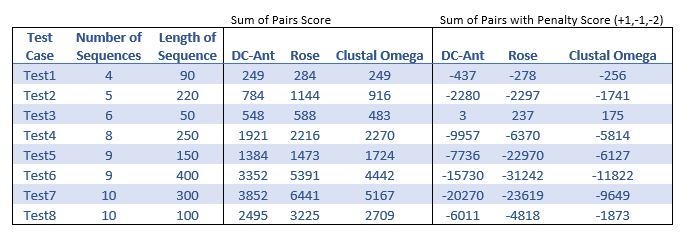

<h3>Time, Memory, and Accuracy vs Number of Sequences</h3>

The results of our benchmarks of time, memory, and accuracy against number of sequences are shown below. 

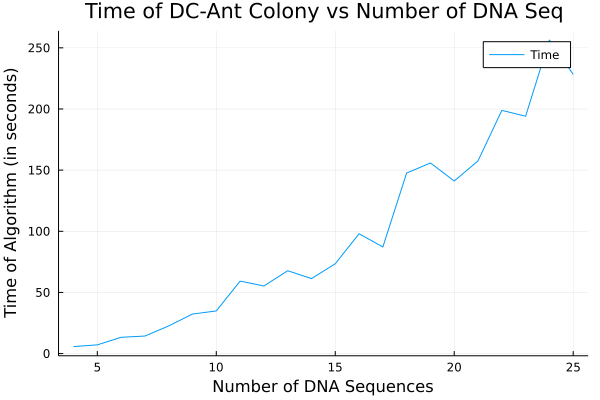

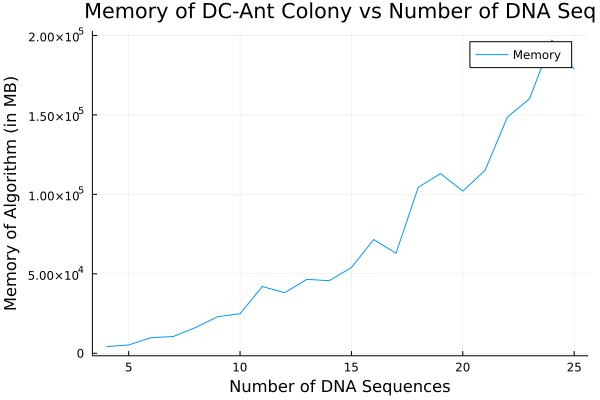

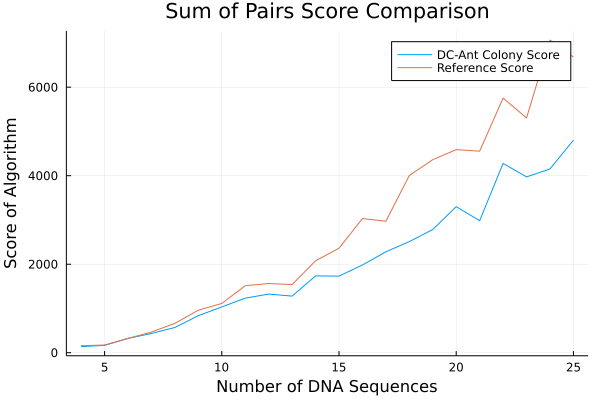

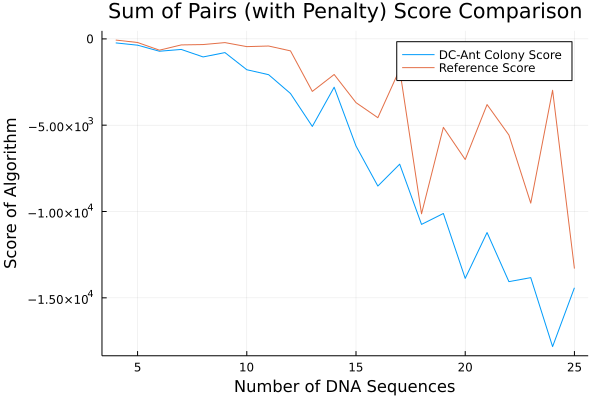

Time and memory both increase quadratically with an increasing number of DNA sequences. Time ranges from roughly 13 seconds for 4 sequences of length 40 to 475 seconds (nearly 8 minutes) for 25 sequences. Memory ranges from 8616 MB for 4 sequences to 325,559 MB for 25 sequences. Accuracy, as indicated by the similarity between our scores and Rose’s, decreases with the number of DNA sequences; our scores are very close for a small number of sequences but deviate for a larger number. 

<h3>Time, Memory, and Accuracy vs Length of Sequences</h3>

The results of our benchmarks of time, memory, and accuracy against length of sequences are shown below.

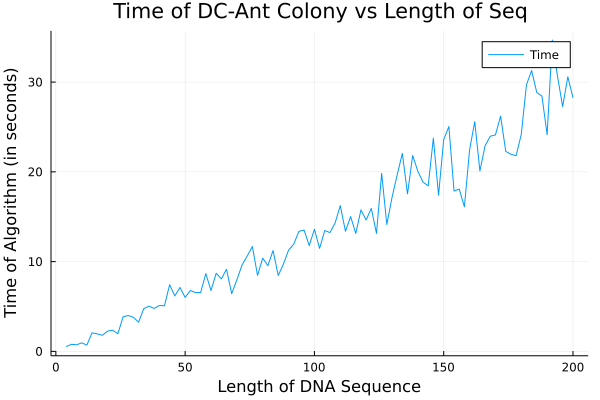

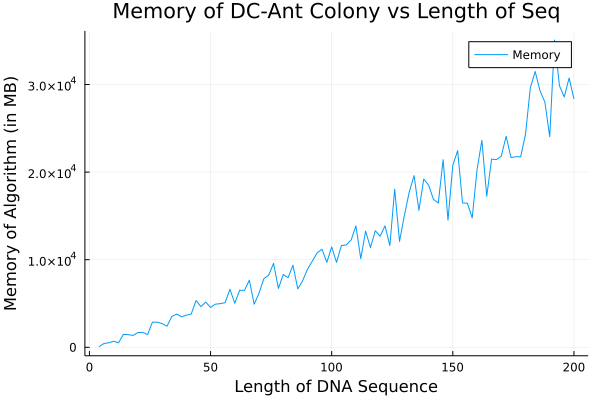

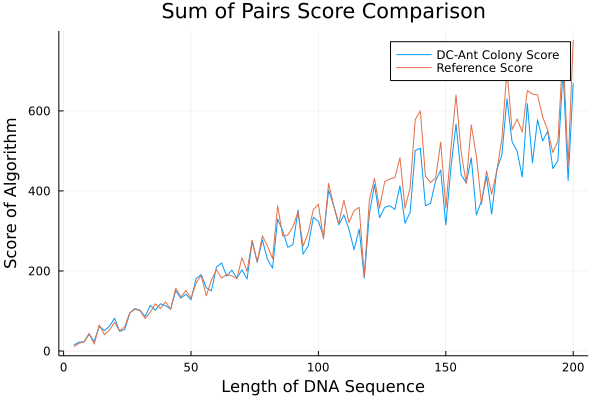

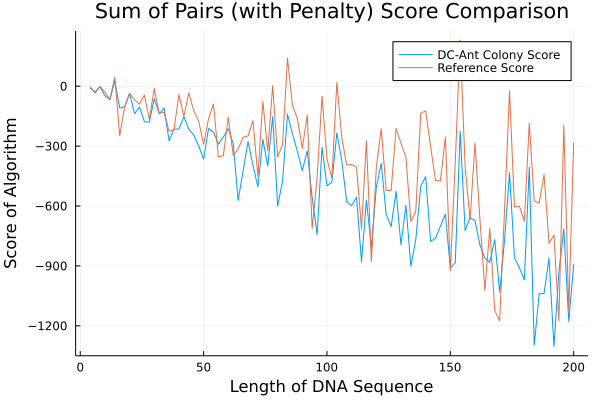

Time and memory appear to increase somewhere between linearly and quadratically -- probably an nlogn relationship -- as the length of DNA sequences increases. However, we see breaks in these graphs unlike when we vary the number of DNA sequences, because as the length increases the number of subsequences we break the DNA sequences into during the Divide and Conquer stage changes (more on this in the Discussion section). Time ranges from 0.08 seconds for sequences of length 4 to 88 seconds for sequences of length 200, while memory ranges from 40 MB to 78,463 MB for the same range of sequence length. As the length of the DNA sequences increases, the Sum of Pair score of our algorithm stays pretty consistent with the Rose score. The Sum of Pairs with Penalty score stays pretty close to the Rose score as well, but is sometimes significantly lower. There are also a few points where our algorithm performed better.

<h2>Discussion</h2>

Overall, our algorithm performed decently, but was not as fast or accurate as we expected. It seems to handle a few sequences pretty well, finishing in under a second for short sequences and about a minute and a half for a sequence of length 200. This plot appears to be an nlogn relationship, which is consistent with what we determined our time complexity to be: both Divide and Conquer and Ant Colony Optimization are O(Len * log(Len)) where Len is the length of the longest sequence. However, as the number of sequences increases, even for relatively short sequences of length 40, the algorithm struggles to keep up, taking over 8 minutes for 25 sequences. The quadratic time complexity we see in the plots is consistent with what we determined our time complexity to be: both Divide and Conquer and Ant Colony Optimization are O(N^2) for sequence number. In terms of accuracy, it seems pretty comparable to Rose, sometimes performing better and sometimes worse, but it always performs significantly worse than Clustal Omega. A similar algorithm by Lee et al (2008), published a year after Liu et al (2007), was very closely matched with Clustal Omega, so we did not perform as well as other similar algorithms from that time. 

There are many factors at play that affect time/memory and accuracy. In theory, more iterations, of both the Divide and Conquer step and the Ant Colony Optimization step, would produce more accurate results, as both should be working towards optimization with each iteration. However, this will obviously require more time and memory. Another tradeoff comes from the size of the subsequences returned from the Divide and Conquer step. We found that shorter subsequences produce results faster, as the time of the Ant Colony Optimization step increases exponentially with the length of the subsequences it has to align (length^num_of_subsequences) . However, we found that at least for longer sequences, this greatly reduced the Sum of Pairs with Penalty score. The reason for this is that each subsequence alignment has to be the same length, so gaps are added at the end of shorter subsequences when they do not have any more nucleotides left to match. When there are many, shorter subsequences, this results in several gaps being added, which hurts the Sum of Pairs with Penalty score. Therefore, we made this minimum sequence length be proportional to the length of the sequences, which through experimentation seemed to be a good balance.

We also found a tradeoff between our two methods of scoring. As the Sum of Pairs with Penalty score improved, the Sum of Pairs score decreased. We determined that this was due to the gap penalty. With enough gaps, the Sum of Pairs score can be great, because every nucleotide can be “aligned.” However, we felt that this was misleading, as there should not actually be that many gaps, so we focused on the Sum of Pairs with Penalty score when optimizing our algorithm.

There are many improvements that can be made to our algorithm. A major one is tweaking all of the parameters. There were over 20 parameters in the Ant Colony Optimization step alone, none of which were given a value in the paper, so we made some educated guesses and tested changing many of them, like the pheromone evaporation rates and the velocity of changing the importance of pheromone, matching score, and location deviation. Ideally we would have had the capacity to methodically test how all of these parameters affected the results as we did with the probability of a space, d, and h.  Another change would be to the Form_Alignment function. This was another missing piece in the paper; it was briefly described in a couple sentences but no detail or pseudocode was given, so it was up to our interpretation. To deal with the end of alignments, any unused nucleotides in a sequence are simply tacked on the end of the aligned sequence, and differences in length are dealt with by filling in with gaps. This was the best method we could think of but probably not ideal, as this leads to mismatched nucleotides and extra gaps at the end of sub-sequences. One way to avoid the gaps would be to not require that each subsequence is the same length and instead deal with the difference in length at the end of the full alignment, removing many gaps from the middle of the alignment, but this may cause later subsequences to become misaligned. Another method would be to address this in the Divide and Conquer stage, requiring that the subsequences in each set of subsequences are of equal length, but this may result in suboptimal cutoffs. 

There were also more experiments we wanted to do but we were limited by time. Our experiments for time, memory, and accuracy vs number of sequences was only done for sequences of length 40, and the comparison of these against length of sequences was only done for 4 sequences. The experiment comparing against the number of sequences should be done for a variety of lengths, and the comparison against length should be done for a variety of the number of sequences. The experiments on the parameters prob_of_space, d, and h, should be performed on more than one test set so we do not only optimize to one set. We also wanted to run experiments on the effects of more parameters. For example, we’d like to see the effects of varying pheromone levels and thresholds, the importance of factors like pheromone, matching score, and location deviation, and the velocities of changing these parameters.
